#Pix2Pix

- CGAN 문제점
  
  CGAN에서는 크지 않은 벡터를 사용하기 때문에 소수 class의 이미지 생성에 문제가 없음
  
  그러나, 특정 대상을 마음대로 생성하거나, 흑백 영상을 칼라 영상으로 바꾸는 것은 거의 불가능하다

- Pix2Pix 의 등장

  생성기의 input이 random vector가 아닌, condition image임

  서로 연관된 pair dataset이 필요

  기존의 CGAN과 다르게,
  1. Generator 가 U-Net 구조를 가짐
  2. loss function 이 L1 + CGAN 의 수식을 가짐
  3. Discriminator 가 PatchGAN을 사용

- Cycle GAN의 등장

  pair dataset을 구하기 어렵고, Cycle GAN이 등장

## Reference
- https://github.com/mrzhu-cool/pix2pix-pytorch/blob/master/train.py
- https://github.com/eriklindernoren/PyTorch-GAN

## loss function

### 기존의 loss function

In [ ]:
loss_func = nn.BCELoss() # 이진 분류

fake_img = model_gen(mask) # mask를 입력 받아 가짜 이미지 생성
out_dis = model_dis(fake_img, conditional_data) # 가짜 이미지를 discriminator이 식별

g_loss = loss_func(fake_img, real_label) # discriminator이 가짜 이미지를 1로 식별하도록 학습

### Pix2Pix loss function

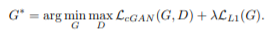

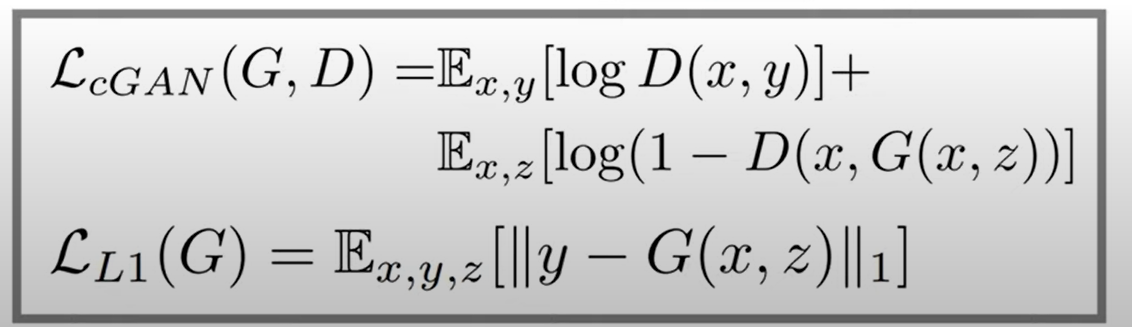

- LcGAN(G,D)
  - 현실적인 이미지를 만들도록 해줌
- lamda*L(G)
  - 실제 정답과 유사하도록 해줌 

In [ ]:
loss_func_gan = nn.BCELoss() # 이진 분류 손실 함수
loss_func_pix = nn.L1Loss() # L1 손실 함수

lambda_pixel = 100 # 가중치

fake_b = model_gen(real_a) # 가짜 이미지 생성
out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

gen_loss = loss_func_gan(out_dis, real_label) # 생성된 가짜 이미지를 discriminator이 진짜로 식별하도록
pixel_loss = loss_func_pix(fake_b, real_b) # 생성된 가짜 이미지와 진짜 이미지의 pixel값 차이

g_loss = gen_loss + lambda_pixel * pixel_loss # generator loss

## 모델 구조 [code]

### import & dataset 불러오고 전처리

In [ ]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch # 깃 클론
!mkdir 'data' # 폴더 생성
!unzip /content/pix2pix-pytorch/dataset/facades.zip  -d /content/data; # 압축 풀기

In [ ]:
# Costum dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)

In [ ]:
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

In [ ]:
# 데이터셋 불러오기
path2img = '/content/data/facades/train'
train_ds = FacadeDataset(path2img, transform=transform)

In [ ]:
# 샘플 이미지 확인하기
a,b = train_ds[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

In [ ]:
# 데이터 로더 생성하기
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

### U-Net Generator 구조

In [ ]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

### Patch GAN Discriminator 구조

In [ ]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x

### 가중치 초기화 및 학습

In [ ]:
model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)

# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

In [ ]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60)

### 결과 확인

In [ ]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

### 테스트

In [ ]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

In [ ]:
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

In [ ]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')

## 모델 구조 [code] - 좀 더 이해해 좋은 코드

### import & dataset 로드

In [ ]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch # 깃 클론
!mkdir 'data' # 폴더 생성
!unzip /content/pix2pix-pytorch/dataset/facades.zip  -d /content/data; # 압축 풀기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from math import log10 # For metric function

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

In [ ]:
# Costum dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)

In [ ]:
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

In [ ]:
# 데이터셋 불러오기

path2img = '/content/data/facades/train'
train_ds = FacadeDataset(path2img, transform=transform)
train_loader = DataLoader(dataset=train_ds, num_workers=0, batch_size=1, shuffle=True)
path2img2 = '/content/data/facades/test'
test_ds2 = FacadeDataset(path2img2, transform=transform)
test_loader = DataLoader(dataset=test_ds2, num_workers=0, batch_size=1, shuffle=False)

In [ ]:
# -1 ~ 1사이의 값을 0~1사이로 만들어준다
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# 이미지 시각화 함수
def show_images(real_a, real_b, fake_b):
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(real_a.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.imshow(real_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(fake_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

### Conv & DeConv 함수

In [ ]:
# Conv -> Batchnorm -> Activate function Layer
'''
코드 단순화를 위한 convolution block 생성을 위한 함수
Encoder에서 사용될 예정
'''
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='relu'):
    layers = []
    
    # Conv layer
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batch Normalization
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
    
    return nn.Sequential(*layers)

# Deconv -> BatchNorm -> Activate function Layer
'''
코드 단순화를 위한 convolution block 생성을 위한 함수
Decoder에서 이미지 복원을 위해 사용될 예정
'''
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)

### Generator - UNet

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu') # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4, activation='lrelu') # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4, activation='lrelu') # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4, activation='lrelu') # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4, activation='lrelu') # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4, activation='lrelu') # (B, 512, 4, 4)
        self.conv7 = conv(512, 512, 4, activation='lrelu') # (B, 512, 2, 2)
        self.conv8 = conv(512, 512, 4, bn=False, activation='relu') # (B, 512, 1, 1)

        # Unet decoder
        self.deconv1 = deconv(512, 512, 4, activation='relu') # (B, 512, 2, 2)
        self.deconv2 = deconv(1024, 512, 4, activation='relu') # (B, 512, 4, 4)
        self.deconv3 = deconv(1024, 512, 4, activation='relu') # (B, 512, 8, 8) # Hint : U-Net에서는 Encoder에서 넘어온 Feature를 Concat합니다! (Channel이 2배)
        self.deconv4 = deconv(1024, 512, 4, activation='relu') # (B, 512, 16, 16)
        self.deconv5 = deconv(1024, 256, 4, activation='relu') # (B, 256, 32, 32)
        self.deconv6 = deconv(512, 128, 4, activation='relu') # (B, 128, 64, 64)
        self.deconv7 = deconv(256, 64, 4, activation='relu') # (B, 64, 128, 128)
        self.deconv8 = deconv(128, 3, 4, activation='tanh') # (B, 3, 256, 256)

    # forward method
    def forward(self, input):
        # Unet encoder
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)
        e7 = self.conv7(e6)
        e8 = self.conv8(e7)
                              
        # Unet decoder
        d1 = F.dropout(self.deconv1(e8), 0.5, training=True)
        d2 = F.dropout(self.deconv2(torch.cat([d1, e7], 1)), 0.5, training=True)
        d3 = F.dropout(self.deconv3(torch.cat([d2, e6], 1)), 0.5, training=True)
        d4 = self.deconv4(torch.cat([d3, e5], 1))
        d5 = self.deconv5(torch.cat([d4, e4], 1))
        d6 = self.deconv6(torch.cat([d5, e3], 1))
        d7 = self.deconv7(torch.cat([d6, e2], 1))
        output = self.deconv8(torch.cat([d7, e1], 1))
        
        return output

### Discriminator - PatchGAN

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(6, 64, 4, bn=False, activation='lrelu')
        self.conv2 = conv(64, 128, 4, activation='lrelu')
        self.conv3 = conv(128, 256, 4, activation='lrelu')
        self.conv4 = conv(256, 512, 4, 1, 1, activation='lrelu')
        self.conv5 = conv(512, 1, 4, 1, 1, activation='none')

    # forward method
    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)

        return out

### 학습 & 결과

In [ ]:
# Generator와 Discriminator를 GPU로 보내기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator().to(device)
D = Discriminator().to(device)

criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

# Setup optimizer
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train
for epoch in range(1, 100):
    for i, (real_a, real_b) in enumerate(train_loader, 1):
        # forward
        real_a, real_b = real_a.to(device), real_b.to(device)
        real_label = torch.ones(1).to(device)
        fake_label = torch.zeros(1).to(device)
        
        fake_b = G(real_a) # G가 생성한 fake Segmentation mask
        
        #============= Train the discriminator =============#
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab.detach())
        loss_d_fake = criterionMSE(pred_fake, fake_label)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = D.forward(real_ab)
        loss_d_real = criterionMSE(pred_real, real_label)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        # Backprop + Optimize
        D.zero_grad()
        loss_d.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab)
        loss_g_gan = criterionMSE(pred_fake, real_label)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad()
        loss_g.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f'
                  % (epoch, 100, i, len(train_loader), loss_d.item(), loss_g.item()))
            print('======================================================================================================')
            show_images(denorm(real_a.squeeze()), denorm(real_b.squeeze()), denorm(fake_b.squeeze()))

## 모델 구조 [이론]

### Generator

- encoder-decoder 이론 기반
  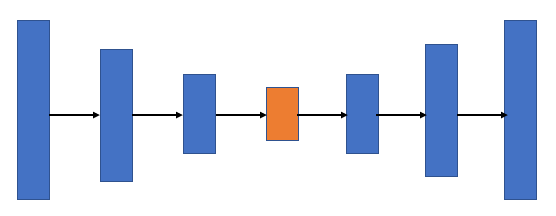

  - encoding 단계에서 차원 축소 단계를 거치며 이미지 객체에 대한 자세한 위치 정보를 잃는다! (위치 정보 손실 회복 불가)


- U-Net 구조

  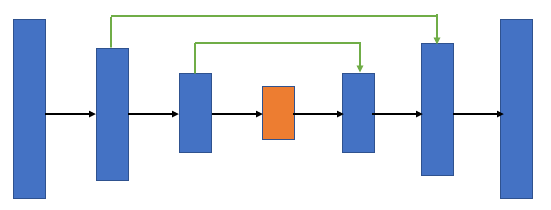
  
  - 저차원 정보 + 고차원 정보 모두 이용해 이미지의 특징 추출 + 정확한 위치 파악
  - encoding 단계의 각 레이어의 특징들을 decoding 단계의 각 레이어에 합치는 방법
  - encoder layer와 decoder layer의 직접 연결 = skip connection

- U-Net 구조 심화

  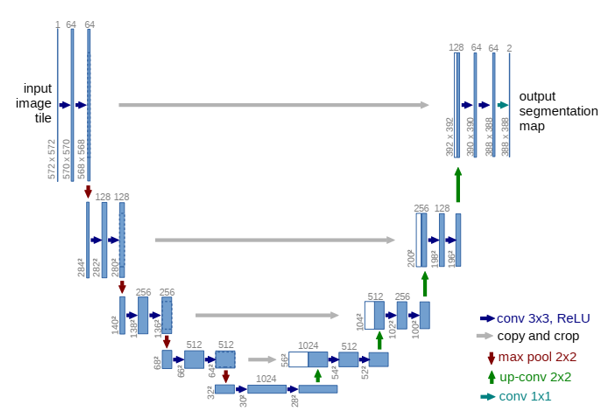

  - encoder, decoder로 이루어짐
  - encoder와 decoder 연결하는 부분 = bridge
  - encoder, decoder 모두 3x3 convolution 사용

- encoder

  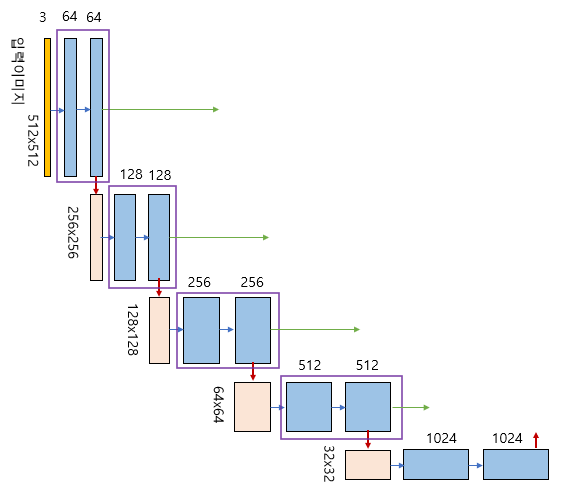

  - 입력 이미지는 512x512x3 (RGB 3채널)
  - 세로 256x256 크기
  - 가로 128 개수

  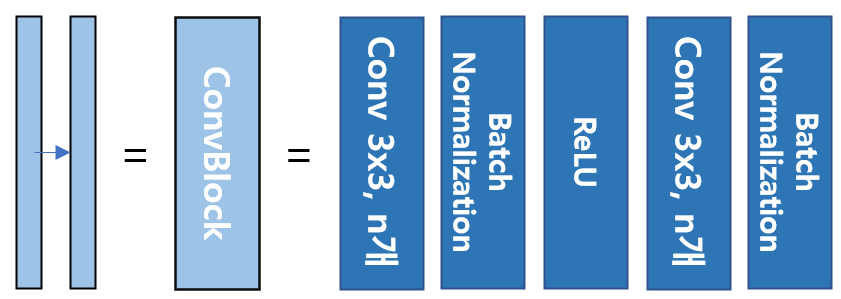

  - 파란색 박스 부분의 반복 구조
  - 3x3 convolution, Batch Normalization, ReLU가 반복되는 구조 = ConvBlock

              """ Conv Block """
        class ConvBlock(tf.keras.layers.Layer):
            def __init__(self, n_filters):
                super(ConvBlock, self).__init__()

                self.conv1 = Conv2D(n_filters, 3, padding='same')
                self.conv2 = Conv2D(n_filters, 3, padding='same')

                self.bn1 = BatchNormalization()
                self.bn2 = BatchNormalization()

                self.activation = Activation('relu')

            def call(self, inputs):
                x = self.conv1(inputs)
                x = self.bn1(x)
                x = self.activation(x)

                x = self.conv2(x)
                x = self.bn2(x)
                x = self.activation(x)

                return x

  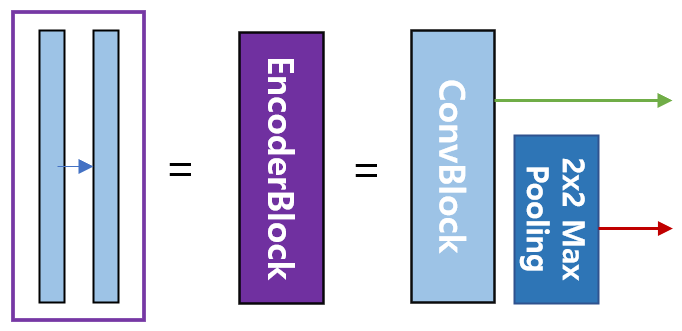

  - 보라색 박스 안에 하나의 ConvBlock이 존재
  - 두 개의 출력, U-Net의 디코더로 복사하기 위한 초록 연결선 + 2x2 max pooling으로 다운 샘플링해 다음 단계로 넘어가는 빨간선
  - EncoderBlock

          """ Encoder Block """
        class EncoderBlock(tf.keras.layers.Layer):
            def __init__(self, n_filters):
                super(EncoderBlock, self).__init__()

                self.conv_blk = ConvBlock(n_filters)
                self.pool = MaxPooling2D((2,2))

            def call(self, inputs):
                x = self.conv_blk(inputs)
                p = self.pool(x)
                return x, p

- decoder

  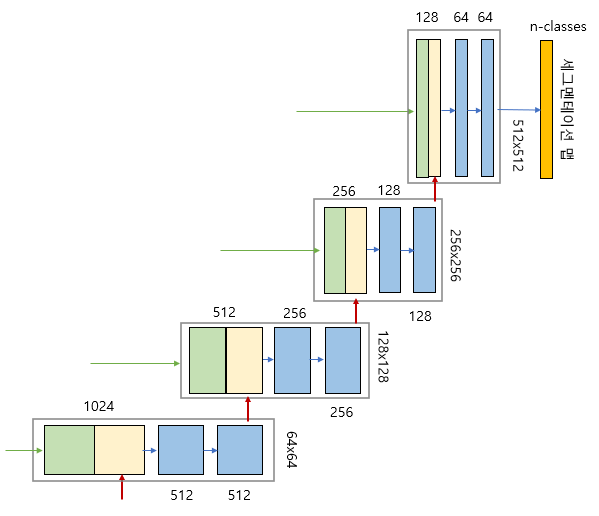

  - 파란 박스 = ConvBlock
  - 노란 박스 = 전치 컨볼루션으로 맵 차원을 두배로 늘림, 차원은 반으로 줄임
  
  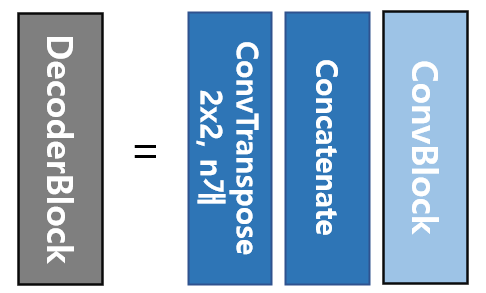

  - 회색 박스 반복적 구조
  - DecoderBlock

          """ Decoder Block """
        class DecoderBlock(tf.keras.layers.Layer):
            def __init__(self, n_filters):
                super(DecoderBlock, self).__init__()

                self.up = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')
                self.conv_blk = ConvBlock(n_filters)

            def call(self, inputs, skip):
                x = self.up(inputs)
                x = Concatenate()([x, skip])
                x = self.conv_blk(x)

                return x

- U-Net

          """ U-Net Model """
        class UNET(tf.keras.Model):
            def __init__(self, n_classes):
                super(UNET, self).__init__()

                # Encoder
                self.e1 = EncoderBlock(64)
                self.e2 = EncoderBlock(128)
                self.e3 = EncoderBlock(256)
                self.e4 = EncoderBlock(512)

                # Bridge
                self.b = ConvBlock(1024)

                # Decoder
                self.d1 = DecoderBlock(512)
                self.d2 = DecoderBlock(256)
                self.d3 = DecoderBlock(128)
                self.d4 = DecoderBlock(64)

                # Outputs
                if n_classes == 1:
                    activation = 'sigmoid'
                else:
                    activation = 'softmax'

                self.outputs = Conv2D(n_classes, 1, padding='same', activation=activation)

            def call(self, inputs):
                s1, p1 = self.e1(inputs)
                s2, p2 = self.e2(p1)
                s3, p3 = self.e3(p2)
                s4, p4 = self.e4(p3)

                b = self.b(p4)

                d1 = self.d1(b, s4)
                d2 = self.d2(d1, s3)
                d3 = self.d3(d2, s2)
                d4 = self.d4(d3, s1)

                outputs = self.outputs(d4)

                return outputs

- import

          # U-Net model
        # coded by st.watermelon

        import tensorflow as tf
        from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
        from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate

- 수식

  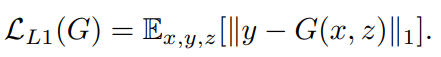

### Discriminator

- PatchGAN
  - 전체 영역이 아닌, 특정 크기의 patch단위로 generator가 생성한 이미지의 진위 여부 판단
  - patch size = hyperparameter
  - generator는 데이터의 일부 특징을 과장하여 discriminator를 속인다
  - 이미지 퀄리티에 상관없이 D만 잘 속이다보니 이미지가 블러가 끼어 나옴
    - loss 구성을 다르게 함
  - 즉, 전체 데이터를 보고 판단하는 것이 아닌, 이웃하고 있는 데이터들과의 관계를 파악

- patchGAN 사용 이유
  - 파라미터 개수 훨씩 적어짐, 연산속도 증가
  - 구조적 관점에서 유연성 (전체에 크게 영향받지 않아)

- patchGAN 구조

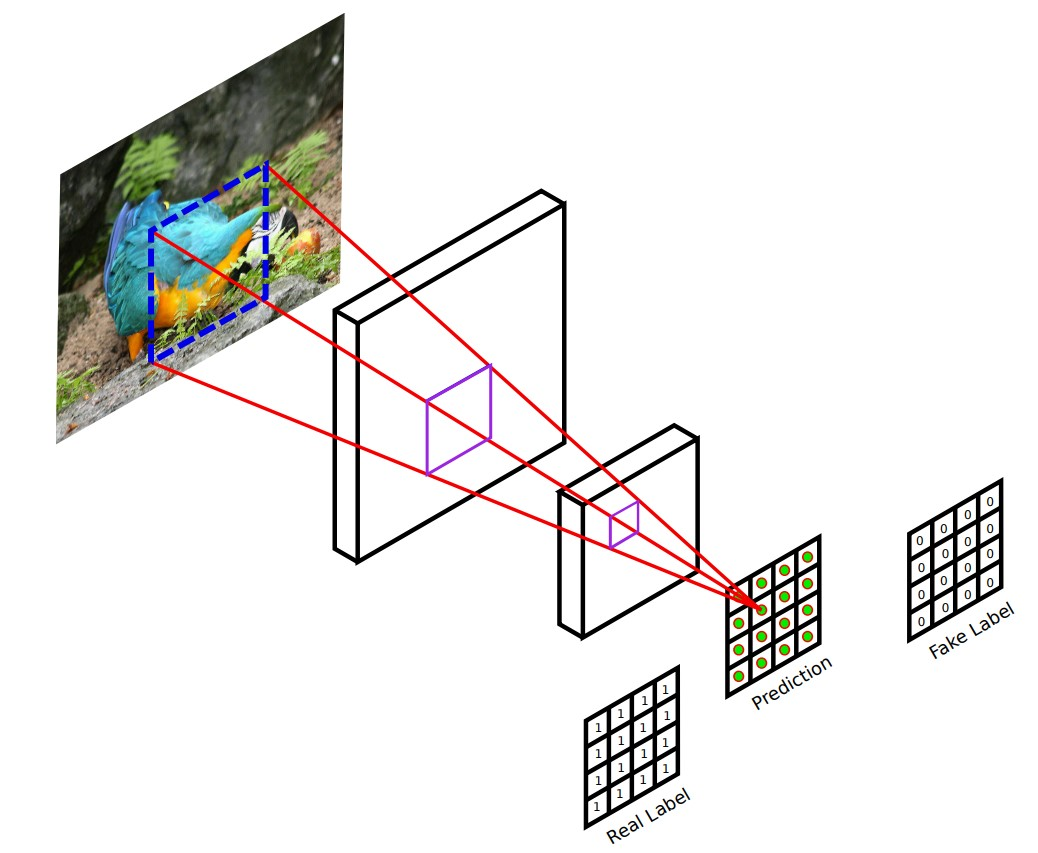

- patchGAN 단계
  1. G가 생성한 256x256 fake 이미지와, 입력 영상을 concat한 후, 30x30 feature map 얻음 (feature map의 1픽셀은, 입력 영상에 대한 70x70 사이즈의 receptive field임)
  2. 30x30x1 feature map을 모두 평균낸 값을 discriminator의 출력으로 한다
  3. L1 loss로 G가 D를 속임뿐 아니라, 정답 이미지(ground truth)와 L1 distance를 줄이는 역할까지 동시 수행
  4. condition(조건)은 G뿐 아니라 D에도 들어가야함 (D가 condition을 보지 않으면 입력과 출력의 차이를 따지지 않게 됨, 성능 안좋음)

- 수식

  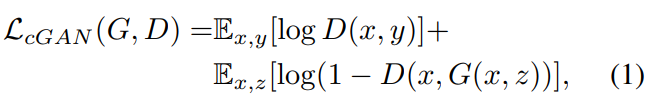

### Loss Function

- 유클리디안 거리 (L2 distance)
  - 모든 출력의 평균을 최소화

- Total Loss

  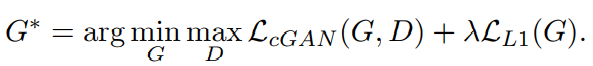